# Group Project Report: Diagnostic Model for Chest Pain

### Section 009 Group 3 (Adeesh Devanand, Eddie Han, Connor Law, Burak Ozkan)

## 1) Introduction

Heart disease is an umbrella term used to define a range of health conditions that **negatively affect** the health of **the heart** or more generally the cardiovascular system, such as **coronary artery disease** which is the narrowing of blood vessels by cholesterol deposits that, especially when it occurs in coronary arteries, **can lead to a heart attack** and sudden death (CDC, 2021). **Chest pain** is a symptom of a heart attack and indicates to the patient that they should seek immediate primary care (NHS, 2023). 

For our project, we would like to explore the following question: **can variables measured during the diagnosis of a heart disease be used to predict the type of chest pain a patient with heart disease might experience during a future heart attack?** We are using the "**Heart Disease Dataset**" by David Lapp, obtained from the Kaggle website (https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset/data) which contains data regarding patients' health predictors, specifically acquired from the **Cleveland data set**, for our model.

We will be using ```cp - chest pain type (4 values)``` as the **response variable**. The classifications are zero to three and their descriptions are as follows:
```
0. non-cardiac causes OR no chest pain.
1. mild or minor chest discomfort, usually of non-cardiac origin.
2. moderate chest pain, which may have cardiac or non-cardiac origins.
3. severe or intense chest pain requiring immediate medical attention.
```

We eliminated all other categorical variables and focused on predictors that are either measurable or well understood by the general public. The **four predictors** of chest pain type are:

```
1 - age        (age)
2 - trestbps   (resting blood pressure)
3 - chol       (cholesterol levels in the blood)
4 - thalach    (maximum heart rate)
```

Some **limitations** of our model include: only incorporating into our model the data taken from patients in the Cleveland, Ohio region, so we cannot be certain that the accuracy of our model will be conserved when used for patients outside of this region; only a subset of clinical factors are being considered for our model, while there are other predictors that can be incorporated into future versions of our model.  

## 2) Methods & Results

#### **a) First, we minimize the number of rows for the tables and call the libraries.**

In [4]:
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
options(repr.matrix.max.rows = 6)
library(repr)
library(tidyverse)
library(tidymodels)
library(themis)
library(RColorBrewer)
library(rvest)
install.packages("kknn")
library("kknn")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [91]:
set.seed(1)

#### **b) Secondly, we import the data from the heart.csv file that we have uploaded to our GitHub server by looking at the raw data and inputting the link into the read_csv function which yields the data.**

In [8]:
url <- read_csv("https://raw.githubusercontent.com/BurakMOzkan/DSCI100_group_3/main/heart.csv?token=GHSAT0AAAAAACLEG5QES2GGPFTSZXYFCYV2ZLNGAFQ")
url

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


#### **c) We then wrangle the data by making the response variable of factor data type, changing its name, selecting for the required variables and renaming the rest of the columns to render them comprehensible without additional metadata.**

In [35]:
heart_disease <- url |>
                 mutate(chest_pain_type = as_factor(cp)) |>
                 select(age, trestbps, chol, thalach, chest_pain_type) |>
                 rename(resting_bp = trestbps,
                        serum_cholesterol = chol,
                        max_heart_rate = thalach) 
heart_disease

age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain_type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
53,140,203,155,0
70,145,174,125,0
⋮,⋮,⋮,⋮,⋮
47,110,275,118,0
50,110,254,159,0
54,120,188,113,0


#### **d) Before we build our model, we divide the data into training and testing data sets, and produce a bar graph to conduct exploratory data analysis.**

In [88]:
hd_split <- initial_split(heart_disease, prop = 0.60, strata = chest_pain_type)
hd_train <- training(hd_split)
hd_test <- testing(hd_split) 
hd_train
hd_split

age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain_type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,125,212,168,0
53,140,203,155,0
62,138,294,106,0
⋮,⋮,⋮,⋮,⋮
58,140,211,165,2
56,120,193,162,3
44,108,141,175,2


<Training/Testing/Total>
<614/411/1025>

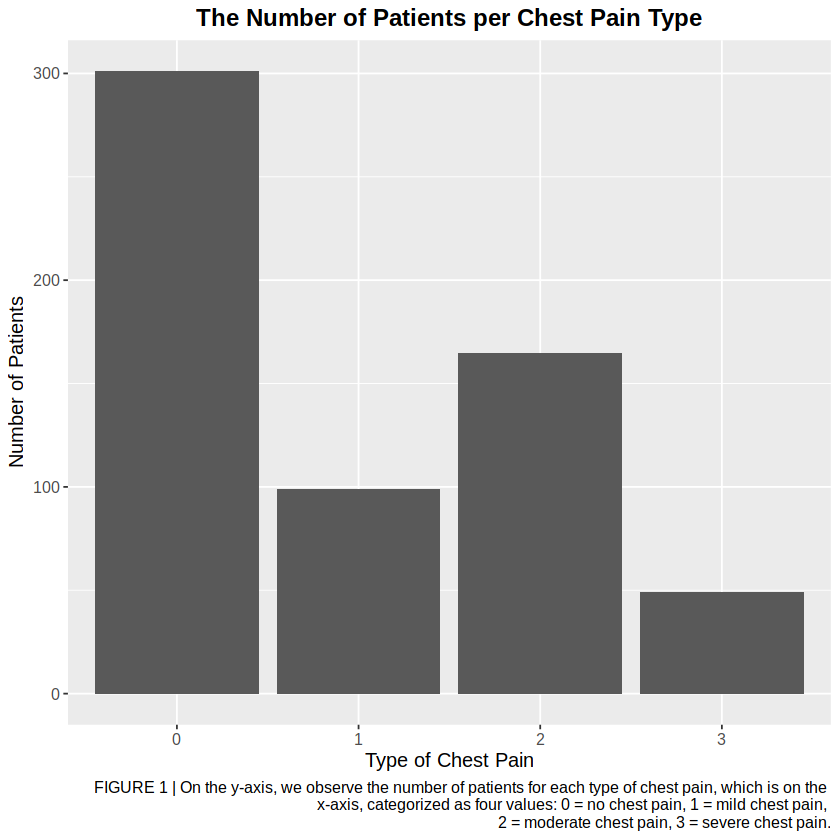

In [89]:
chest_pain_bar <- hd_train |>
                  ggplot(aes(x = chest_pain_type)) +
                  geom_bar() +
                  labs(x = "Type of Chest Pain", y = "Number of Patients",  fill = "Chest Pain Type",
                       title = "The Number of Patients per Chest Pain Type",
                       caption = "FIGURE 1 | On the y-axis, we observe the number of patients for each type of chest pain, which is on the 
                                  x-axis, categorized as four values: 0 = no chest pain, 1 = mild chest pain, 
                                  2 = moderate chest pain, 3 = severe chest pain.") +
                  theme(text = element_text(size = 12),
                        plot.title = element_text(hjust = 0.5, face = "bold"),
                        plot.caption = element_text(colour = "black")) 
chest_pain_bar

 - We observe that most samples of the training data set have the value 0, meaning no chest pain or chest pain not related to the heart, which can instead be musculoskeletal pain (Liu, 2019). 
 - The minority class which is 3 **has less than 20%** of the data found in the largest class which is 0.
 - Therefore, we will consider **upsampling** our data to promote model stability.

#### **e) Before we train the classifier, we should preprocess the data as it is sensitive to the scale of the predictors and oversample to balance the data, as mentioned above.**

In [104]:
hd_recipe_upsampling <- recipe(chest_pain_type ~ ., data = hd_train) |>
                        step_upsample(chest_pain_type, over_ratio = 1, skip = FALSE) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) |>
                        prep()
hd_recipe_upsampling

hd_upsampled <- bake(hd_recipe_upsampling, hd_train) |>
                group_by(chest_pain_type) |>
                summarize(n = n())
hd_upsampled

hd_train_2 <- bake(hd_recipe_upsampling, hd_train)
hd_train_2

hd_recipe <- recipe(chest_pain_type ~ ., data = hd_train) |>
             step_scale(all_predictors()) |>
             step_center(all_predictors())
hd_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Training data contained 614 data points and no missing data.

Operations:

Up-sampling based on chest_pain_type [trained]
Scaling for age, resting_bp, serum_cholesterol, max_heart_rate [trained]
Centering for age, resting_bp, serum_cholesterol, max_heart_rate [trained]

chest_pain_type,n
<fct>,<int>
0,301
1,301
2,301
3,301


age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain_type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.2111604,-0.4092360,-0.6386606,0.69580521,0
-0.1060168,0.3969161,-0.8321119,0.09695207,0
0.8402751,0.2894291,1.1238956,-2.16026359,0
⋮,⋮,⋮,⋮,⋮
1.050562,-1.215388,-0.6601552,-0.40976981,3
1.576280,1.471786,-0.1657797,-1.00862295,3
1.050562,2.009220,-0.3162418,0.09695207,3


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Operations:

Scaling for all_predictors()
Centering for all_predictors()

- We now observe that all chest pain types have the **same number** of observations: one class is not greater than another class.

#### **f) We can now train the classifier by randomly using K = 4.**

In [108]:
hd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
           set_engine("kknn") |>
           set_mode("classification")
hd_spec

hd_fit <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(hd_spec) |>
          fit(data = hd_train_2)
hd_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 4
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1038206
Best kernel: rectangular
Best k: 4

#### **g) Adding our predictions column to the data set.**

In [109]:
hd_predictions <- predict(hd_fit, hd_test) |>
                  bind_cols(hd_test)
hd_predictions

.pred_class,age,resting_bp,serum_cholesterol,max_heart_rate,chest_pain_type
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,70,145,174,125,0
2,61,148,203,161,0
2,46,120,249,144,0
⋮,⋮,⋮,⋮,⋮,⋮
2,59,140,221,164,1
2,60,125,258,141,0
2,50,110,254,159,0


#### **h) Let's assess the performance of the classifier and see if we need to choose a different K value.**

In [110]:
hd_accuracy <- hd_predictions |>
               metrics(truth = chest_pain_type, estimate = .pred_class) |>
               filter(.metric == "accuracy")
hd_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.2846715


In [111]:
matrix <- hd_predictions |>
          conf_mat(truth = chest_pain_type, estimate = .pred_class)
matrix

          Truth
Prediction   0   1   2   3
         0   0   0   0   0
         1   0   0   2   0
         2 196  68 117  28
         3   0   0   0   0

**The accuracy is not great at all for K = 4 and we can see in the confusion matrix that the predictions are not always in line with the truth. Therefore, we need to further evaluate our model to increase its accuracy if we hope to use it in clinical applications.**

#### **i) Employing cross-validation, we can determine the best value for K.**

In [112]:
hd_vfold <- vfold_cv(hd_train, v = 5, strata = chest_pain_type)

hd_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
             set_engine("kknn") |>
             set_mode("classification")

hd_k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

hd_results <- workflow() |>
              add_recipe(hd_recipe) |>
              add_model(hd_spec_2) |>
              tune_grid(resamples = hd_vfold, grid = hd_k_vals) |>
              collect_metrics() 

hd_accuracies <- hd_results |>
                 filter(.metric == "accuracy")
hd_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8224896,5,0.018020426,Preprocessor1_Model01
2,accuracy,multiclass,0.8224896,5,0.018020426,Preprocessor1_Model02
3,accuracy,multiclass,0.6221711,5,0.003318832,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,multiclass,0.5002271,5,0.01433148,Preprocessor1_Model28
29,accuracy,multiclass,0.5035192,5,0.01804589,Preprocessor1_Model29
30,accuracy,multiclass,0.4921233,5,0.01899177,Preprocessor1_Model30


#### **j) Plot the accuracies to pick a value for K.**

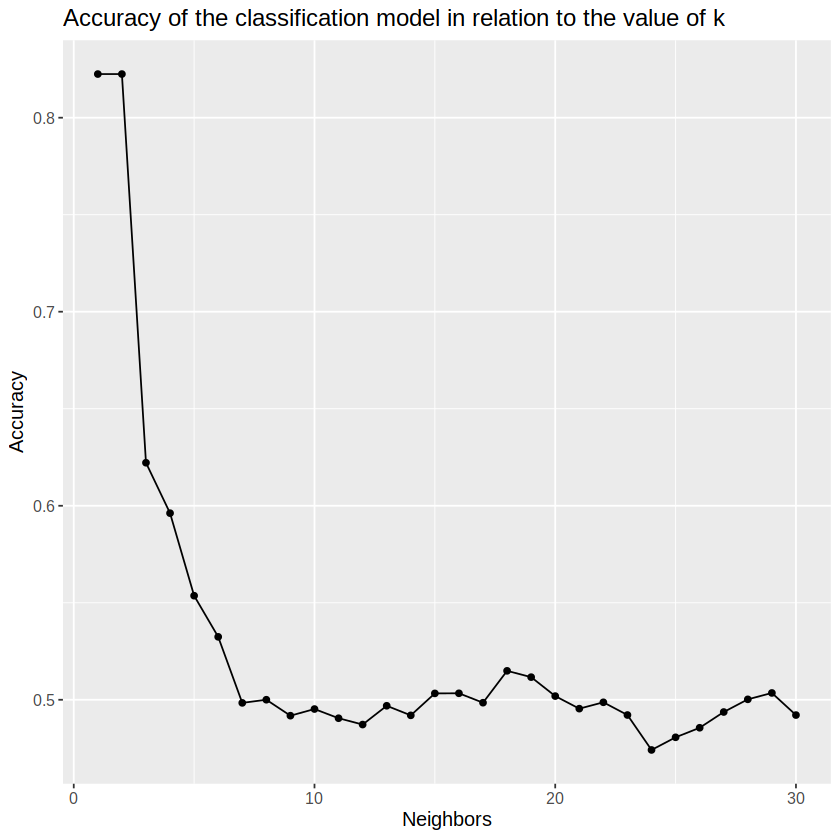

In [113]:
which_k <- hd_accuracies |>
           ggplot(aes(x = neighbors, y = mean)) +
           geom_point() +
           geom_line() +
           labs(x = "Neighbors", y = "Accuracy") + 
           ggtitle("Accuracy of the classification model in relation to the value of k") +
           theme(text = element_text(size = 12))
which_k

**In the graph presented above, a huge drop in accuracy can be observed as the chosen value of k increases past 2. **

In [116]:
hd_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
           set_engine("kknn") |>
           set_mode("classification")

hd_fit_best <- workflow() |>
          add_recipe(hd_recipe) |>
          add_model(hd_spec_best) |>
          fit(data = hd_train)

hd_predictions_best <- predict(hd_fit_best, hd_test) |>
                  bind_cols(hd_test)

hd_accuracy_best <- hd_predictions_best |>
               metrics(truth = chest_pain_type, estimate = .pred_class) |>
               filter(.metric == "accuracy")

matrix_best <- hd_predictions_best |>
    conf_mat(truth = chest_pain_type, estimate = .pred_class)

hd_accuracy_best
matrix_best

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9245742


          Truth
Prediction   0   1   2   3
         0 183   3   6   0
         1   6  62   6   0
         2   7   3 107   0
         3   0   0   0  28

#### **k) Determine the importance of each predictor in predicting the chest pain type.**

In [123]:
test_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
           set_engine("kknn") |>
           set_mode("classification")

# age
age_recipe <- recipe(chest_pain_type ~ age, data = hd_train)

age_fit <- workflow() |>
           add_recipe(age_recipe) |>
           add_model(test_spec) |>
           fit(data = hd_train)

age_predictions <- predict(age_fit, hd_test) |>
                   bind_cols(hd_test)

age_matrix <- age_predictions |>
    conf_mat(truth = chest_pain_type, estimate = .pred_class)

age_matrix

          Truth
Prediction   0   1   2   3
         0 193  58 109  22
         1   3   8   5   0
         2   0   0   3   2
         3   0   2   2   4

In [62]:
# resting_bp
resting_bp_recipe <- recipe(chest_pain_type ~ resting_bp, data = hd_train)

resting_bp_fit <- workflow() |>
          add_recipe(resting_bp_recipe) |>
          add_model(test_spec) |>
          fit(data = hd_train)

resting_bp_predictions <- predict(resting_bp_fit, hd_test) |>
                  bind_cols(hd_test)

resting_bp_matrix <- resting_bp_predictions |>
    conf_mat(truth = chest_pain_type, estimate = .pred_class)

resting_bp_matrix

          Truth
Prediction  0  1  2  3
         0 96 28 52 19
         1  3  2  0  0
         2  0  0  2  0
         3  0  1  3  1

In [63]:
# serum_cholesterol
serum_cholesterol_recipe <- recipe(chest_pain_type ~ serum_cholesterol, data = hd_train)

serum_cholesterol_fit <- workflow() |>
          add_recipe(serum_cholesterol_recipe) |>
          add_model(test_spec) |>
          fit(data = hd_train)

serum_cholesterol_recipe_predictions <- predict(serum_cholesterol_fit, hd_test) |>
                  bind_cols(hd_test)

serum_cholesterol_fit_matrix <- serum_cholesterol_recipe_predictions |>
    conf_mat(truth = chest_pain_type, estimate = .pred_class)

serum_cholesterol_fit_matrix

          Truth
Prediction  0  1  2  3
         0 85 15 27  9
         1  4 12  7  5
         2 10  4 20  6
         3  0  0  3  0

In [124]:
# max_heart_rate
max_heart_rate_recipe <- recipe(chest_pain_type ~ max_heart_rate, data = hd_train)

max_heart_rate_fit <- workflow() |>
          add_recipe(max_heart_rate_recipe) |>
          add_model(test_spec) |>
          fit(data = hd_train)

max_heart_rate_predictions <- predict(max_heart_rate_fit, hd_test) |>
                  bind_cols(hd_test)

max_heart_rate_matrix <- max_heart_rate_predictions |>
    conf_mat(truth = chest_pain_type, estimate = .pred_class)

max_heart_rate_matrix

          Truth
Prediction   0   1   2   3
         0 181  38  81  23
         1   6  27  12   2
         2   9   3  26   0
         3   0   0   0   3

## 3) Discussion

#### **a) Results**

#### **b) Was this what was expected?**

#### **c) What impact can these findings have?**

#### **d) What are some future questions this analysis may lead to?**

## 4) References

Centers for Disease Control and Prevention. (2021, July 19). Coronary artery disease. Centers for Disease Control and Prevention. https://www.cdc.gov/heartdisease/coronary_ad.htm#:~:text=Print-,Coronary%20Artery%20Disease,This%20process%20is%20called%20atherosclerosis. 

NHS. (n.d.). Heart Attack. NHS choices. 
https://www.nhs.uk/conditions/heart-attack/symptoms/ 